In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from mlp import MLP
from model_simple_conv import ConvNet

DIR_PATH = os.getcwd() + '/../'

In [3]:
demo_data_name = 'demos_reach_object_no_distractors_48_16x16'
data_traj = np.load(DIR_PATH + 'data/' + demo_data_name + '.npz')

x = data_traj['demo_image_sequences']
y = data_traj['demo_action_sequences']
step_marker = np.concatenate([[0], data_traj['step_marker']])

n_steps = len(y)
n_seq = len(step_marker) - 1
print('Number of sequences:', n_seq)
print('Total number of steps:', n_steps)
print('step_marker:\n', step_marker)
print('steps_per_traj:\n', step_marker[1:] - step_marker[:-1])

Number of sequences: 48
Total number of steps: 6033
step_marker:
 [   0  112  223  355  475  591  731  876 1010 1155 1291 1404 1534 1646
 1781 1892 2036 2167 2287 2421 2534 2666 2781 2907 3034 3159 3292 3405
 3527 3642 3767 3912 4024 4141 4260 4394 4510 4622 4735 4861 4983 5133
 5261 5373 5522 5643 5762 5896 6033]
steps_per_traj:
 [112 111 132 120 116 140 145 134 145 136 113 130 112 135 111 144 131 120
 134 113 132 115 126 127 125 133 113 122 115 125 145 112 117 119 134 116
 112 113 126 122 150 128 112 149 121 119 134 137]


In [4]:
# Split
random_traj_idx = np.random.permutation(n_seq)

n_val = int(0.2 * n_seq)
n_train = n_seq - n_val

val_trajs = random_traj_idx[: n_val]
train_trajs = random_traj_idx[n_val : n_val+n_train]

val_idx = np.concatenate([np.arange(step_marker[i], step_marker[i+1]) for i in val_trajs])
train_idx = np.concatenate([np.arange(step_marker[i], step_marker[i+1]) for i in train_trajs])

val_x = x[val_idx]
val_y = y[val_idx]

train_x = x[train_idx]
train_y = y[train_idx]

print(n_train, train_x.shape)
print(n_val, val_x.shape)

39 (4897, 16, 16, 3)
9 (1136, 16, 16, 3)


In [5]:
# Analyse (train set only)
print(train_x.min(axis=(0,1,2)))
print(train_x.max(axis=(0,1,2)))
print(train_x.mean(axis=(0,1,2)))
print(train_x.std(axis=(0,1,2)))
print()
print(np.concatenate([train_y.min(axis=0).reshape(-1, 1), train_y.max(axis=0).reshape(-1, 1)], axis=1))

[0.04313726 0.08235294 0.08235294]
[0.85490197 0.8352941  0.81960785]
[0.6440029  0.5449768  0.40504277]
[0.2450152  0.17825265 0.19122405]

[[-0.00286086  0.00477268]
 [-0.00465913  0.00463562]
 [-0.00499201  0.00164759]]


In [6]:
train_y.mean(axis=0)

array([-0.00052942, -0.00015471, -0.00302007])

In [7]:
train_y.std(axis=0)

array([0.00145716, 0.0018421 , 0.00207329])

In [8]:
np.savez(DIR_PATH + 'data/model_out_mean_std.npz', mean=train_y.mean(axis=0), std=train_y.std(axis=0))

In [9]:
print((train_y[:, 1] > 0).sum(), (train_y[:, 1] < 0).sum())
print((val_y[:, 1] > 0).sum(), (val_y[:, 1] < 0).sum())

1947 2950
768 368


In [10]:
'''
def normalize(x_data, y_data):
    normal_x = x_data
    normal_y = (y_data - train_y.mean(axis=0).reshape(1, -1)) / train_y.std(axis=0).reshape(1, -1)
    return normal_x, normal_y
'''
def normalize(x_data, y_data):
    normal_x = x_data
    normal_y = y_data * 1000
    return normal_x, normal_y

normal_train_x, normal_train_y = normalize(train_x, train_y)
normal_val_x, normal_val_y = normalize(val_x, val_y)

In [11]:
for i in range(3):
    print(normal_train_x[:,:,:,i].min(), normal_train_x[:,:,:,i].max())
    
for i in range(3):
    print(normal_train_y[:,i].min(), normal_train_y[:,i].max())

0.043137256 0.85490197
0.08235294 0.8352941
0.08235294 0.81960785
-2.8608636012087887 4.772678245756237
-4.659125428137049 4.635622192621667
-4.9920119443105815 1.6475915908813477


In [12]:
class DemoDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.x = torch.as_tensor(data_x, dtype=torch.float32).permute(0, 3, 1, 2)
        self.y = torch.as_tensor(data_y, dtype=torch.float32)[:, :3]
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [13]:
train_set = DemoDataset(normal_train_x, normal_train_y)
v_set = DemoDataset(normal_val_x, normal_val_y)

#train_set = DemoDataset(train_x, train_y)
#v_set = DemoDataset(val_x, val_y)

In [14]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True)
v_loader = DataLoader(v_set, batch_size=64, shuffle=False, drop_last=False)

train_loader.dataset.x.shape, train_loader.dataset.y.shape, v_loader.dataset.x.shape, v_loader.dataset.y.shape

(torch.Size([4897, 3, 16, 16]),
 torch.Size([4897, 3]),
 torch.Size([1136, 3, 16, 16]),
 torch.Size([1136, 3]))

In [15]:
model = ConvNet(n_classes=3)
#model = MLP(layers_dim=(16*16*3, 16, 3))
print('MODEL INFO:', model, sep='\n')

MODEL INFO:
ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=16, out_features=3, bias=True)
  )
)


In [16]:
sum_total_learnable_params = 0
for param in model.parameters():
    print(param.shape)
    sum_total_learnable_params += np.prod(np.array(param.shape))
print("Number of learnable parameters:", sum_total_learnable_params)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([256, 128, 4, 4])
torch.Size([256])
torch.Size([16, 256])
torch.Size([16])
torch.Size([3, 16])
torch.Size([3])
Number of learnable parameters: 604355


In [18]:
def train(model, train_loader, v_loader, n_epochs):
    device = torch.device('cpu')
    model.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    loss_logger = {'loss':[], 'vloss':[], 'loss_class':[], 'vloss_class':[]}

    for epoch in range(n_epochs):
        #print(f"Starting epoch {epoch}/{n_epochs}", end=" ")
        for batch, (x, y) in enumerate(train_loader):
            model.train()
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model.forward(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            if batch % 1 == 0:
                model.eval()
                with torch.no_grad():
                    loss_logger['loss'].append(loss.item())
                    loss_per_class = ((y - y_pred)**2).mean(axis=0).numpy()
                    loss_logger['loss_class'].append(loss_per_class)
                    x_val, y_val = v_loader.dataset.x.to(device), v_loader.dataset.y.to(device)
                    y_pred = model.forward(x_val)
                    v_loss_per_class = ((y_val - y_pred)**2).mean(axis=0).numpy()
                    v_loss = v_loss_per_class.mean().item()
                    loss_logger['vloss'].append(v_loss)
                    loss_logger['vloss_class'].append(v_loss_per_class)
        #print('vloss', loss.item())
    return loss_logger

In [26]:
model = ConvNet(n_classes=3)
#model = MLP(layers_dim=(16*16*3, 16, 3))
loss_log = train(model, train_loader, v_loader, n_epochs=100)

In [29]:
torch.save(model.state_dict(), DIR_PATH + '/data/model_conv_simple_general_no_distractors.pth')

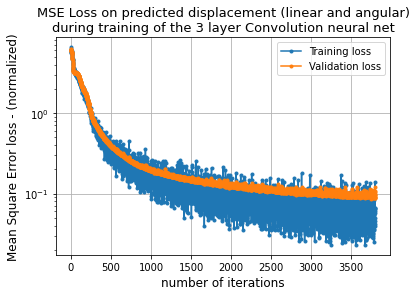

In [27]:
plt.plot(loss_log['loss'], '.-', label='Training loss')
plt.plot(loss_log['vloss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted displacement (linear and angular)\nduring training of the 3 layer Convolution neural net", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("number of iterations", fontsize=12)
plt.yscale('log')
plt.legend()
plt.grid()

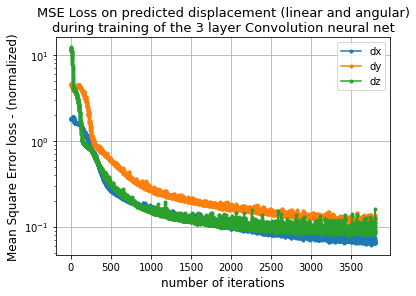

In [28]:
plt.plot(np.stack(loss_log['vloss_class']), '.-')
plt.yscale('log')
#plt.plot(loss_log['loss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted displacement (linear and angular)\nduring training of the 3 layer Convolution neural net", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("number of iterations", fontsize=12)
plt.legend(('dx', 'dy', 'dz'))
plt.grid()

In [80]:
min(loss_log['vloss']), min(loss_log['loss']), np.stack(loss_log['vloss_class']).min(axis=0), np.stack(loss_log['loss_class']).min(axis=0)

(0.047621648758649826,
 0.005363536532968283,
 array([0.01414675, 0.00683496, 0.11898609], dtype=float32),
 array([0.00706524, 0.00063498, 0.00839038], dtype=float32))

In [89]:
min(loss_log['vloss']), min(loss_log['loss']), np.stack(loss_log['vloss_class']).min(axis=0), np.stack(loss_log['loss_class']).min(axis=0)

(0.04508332535624504,
 0.00016074439918156713,
 array([0.01210704, 0.0057893 , 0.1138881 ], dtype=float32),
 array([2.0224743e-05, 1.1512718e-05, 1.5566341e-04], dtype=float32))

In [100]:
min(loss_log['vloss']), min(loss_log['loss']), np.stack(loss_log['vloss_class']).min(axis=0), np.stack(loss_log['loss_class']).min(axis=0)

(0.04507988691329956,
 2.755519290076336e-06,
 array([0.01241518, 0.00614436, 0.11282728], dtype=float32),
 array([1.2787652e-06, 7.2160702e-07, 3.0097694e-06], dtype=float32))

In [116]:
min(loss_log['vloss']), min(loss_log['loss']), np.stack(loss_log['vloss_class']).min(axis=0), np.stack(loss_log['loss_class']).min(axis=0)

(0.040911413729190826,
 4.6048546209931374e-05,
 array([0.00737013, 0.00307417, 0.10929243], dtype=float32),
 array([1.2397300e-05, 5.9023705e-06, 3.3040960e-05], dtype=float32))

In [109]:
min(loss_log['vloss']), min(loss_log['loss']), np.stack(loss_log['vloss_class']).min(axis=0), np.stack(loss_log['loss_class']).min(axis=0)

(0.045499976724386215,
 0.0003296082722954452,
 array([0.01178504, 0.00482231, 0.11758278], dtype=float32),
 array([2.5333170e-04, 8.8227134e-05, 5.6912698e-04], dtype=float32))

In [30]:
min(loss_log['vloss']), min(loss_log['loss']), np.stack(loss_log['vloss_class']).min(axis=0), np.stack(loss_log['loss_class']).min(axis=0)

(0.0008530134800821543,
 0.00022022316989023238,
 array([0.00032457, 0.00010451, 0.00195901], dtype=float32),
 array([1.1373230e-04, 2.2420722e-05, 2.7805203e-04], dtype=float32))

In [42]:
min(loss_log['vloss']), min(loss_log['loss']), np.stack(loss_log['vloss_class']).min(axis=0), np.stack(loss_log['loss_class']).min(axis=0)

(0.0018997996812686324,
 0.00032760491012595594,
 array([0.00111363, 0.00102404, 0.00330554], dtype=float32),
 array([1.2053708e-04, 7.6013472e-05, 3.5185672e-04], dtype=float32))

In [65]:
min(loss_log['vloss']), min(loss_log['loss']), np.stack(loss_log['vloss_class']).min(axis=0), np.stack(loss_log['loss_class']).min(axis=0)

(0.0011304187355563045,
 0.00016864523058757186,
 array([0.00055865, 0.00032386, 0.00229583], dtype=float32),
 array([2.5091449e-05, 1.4634576e-05, 1.0948779e-04], dtype=float32))